# Imports
All imports should be defined here to reduce clutter

In [1]:
import random

import numpy as np
import pygame
import torch
import cv2
import torchvision
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
import matplotlib.pyplot as plot
from NovelSwarmBehavior.novel_swarms.config.EvolutionaryConfig import GeneticEvolutionConfig
from NovelSwarmBehavior.novel_swarms.config.WorldConfig import RectangularWorldConfig
from NovelSwarmBehavior.novel_swarms.config.defaults import ConfigurationDefaults
from NovelSwarmBehavior.novel_swarms.novelty.GeneRule import GeneRule
from NovelSwarmBehavior.novel_swarms.config.OutputTensorConfig import OutputTensorConfig
from NovelSwarmBehavior.novel_swarms.novelty.NoveltyArchive import NoveltyArchive

from networks.encoder import BehaviorAutoEncoder

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

pygame 2.1.2 (SDL 2.0.16, Python 3.10.4)
Hello from the pygame community. https://www.pygame.org/contribute.html
cuda


# Auto Encoder

In [2]:
# Load a pre-trained AutoEncoder
encoder = BehaviorAutoEncoder()
encoder.load_model("cp_C-105")
encoder.to(device)
encoder.eval()

BehaviorAutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=40000, out_features=8192, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8192, out_features=2048, bias=True)
    (3): ReLU()
    (4): Linear(in_features=2048, out_features=1024, bias=True)
    (5): ReLU()
    (6): Linear(in_features=1024, out_features=256, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=256, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=2048, bias=True)
    (3): ReLU()
    (4): Linear(in_features=2048, out_features=8192, bias=True)
    (5): ReLU()
    (6): Linear(in_features=8192, out_features=40000, bias=True)
    (7): Sigmoid()
  )
)

In [23]:
import time
class NoveltyScoreMixer(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.s1 = torch.nn.Sequential(
            torch.nn.Linear(2, 1)
        )

    def forward(self, x):
        x = self.s1(x)
        return x

    def load_model(self, file_name="cp_NAME"):
        checkpoint = torch.load(f"checkpoints/encoder/{file_name}.pt")
        self.load_state_dict(checkpoint["model_state_dict"])

    def save_model(self):
        file_name = f"cp_{round(time.time())}"
        torch.save({
            'model_state_dict': self.state_dict(),
        }, f"checkpoints/mixer/{file_name}.pt")

# Generator

In [4]:
def getGenerator(steps=1200):
    agent_config = ConfigurationDefaults.DIFF_DRIVE_AGENT

    genotype = [
        GeneRule(_max=1.0, _min=-1.0, mutation_step=0.4, round_digits=4),
        GeneRule(_max=1.0, _min=-1.0, mutation_step=0.4, round_digits=4),
        GeneRule(_max=1.0, _min=-1.0, mutation_step=0.4, round_digits=4),
        GeneRule(_max=1.0, _min=-1.0, mutation_step=0.4, round_digits=4),
    ]

    phenotype = ConfigurationDefaults.BEHAVIOR_VECTOR

    world_config = RectangularWorldConfig(
        size=(500, 500),
        n_agents=30,
        behavior=phenotype,
        agentConfig=agent_config,
        padding=15
    )

    novelty_config = GeneticEvolutionConfig(
        gene_rules=genotype,
        phenotype_config=phenotype,
        n_generations=100,
        n_population=100,
        crossover_rate=0.7,
        mutation_rate=0.15,
        world_config=world_config,
        k_nn=15,
        simulation_lifespan=steps,
        display_novelty=False,
        save_archive=False,
        show_gui=True
    )

    pygame.init()
    pygame.display.set_caption("Evolutionary Novelty Search")
    screen = pygame.display.set_mode((world_config.w, world_config.h))

    output_config = OutputTensorConfig(
        timeless=True,
        total_frames=80,
        steps_between_frames=2,
        screen=screen
    )

    halted_evolution = HaltedEvolution(
        world=world_config,
        evolution_config=novelty_config,
        output_config=output_config
    )

    return halted_evolution, screen

def resizeInput(X):
    frame = X.astype(np.uint8)
    resized = cv2.resize(frame, dsize=(200, 200), interpolation=cv2.INTER_CUBIC)
    return resized

Eval Time
[0.3491578  0.34333921 0.39223814 0.36195487 0.30682999 0.30571602
 0.47624596 0.38664907 0.32137834 0.32459757 0.51689213 0.29111826
 0.60311942 0.49031414 0.86177459 0.51033979 0.35177418 0.49451645
 0.3272695  0.63163402]
[(tensor([-0.2991]), 0), (tensor([-0.2991]), 1), (tensor([-0.2991]), 2), (tensor([-0.2991]), 3), (tensor([-0.2991]), 4), (tensor([-0.2991]), 5), (tensor([-0.2991]), 6), (tensor([-0.2991]), 7), (tensor([-0.2991]), 8), (tensor([-0.2991]), 9), (tensor([-0.2991]), 10), (tensor([-0.2991]), 11), (tensor([-0.2991]), 12), (tensor([-0.2991]), 13), (tensor([-0.2991]), 14), (tensor([-0.2991]), 15), (tensor([-0.2991]), 16), (tensor([-0.2991]), 17), (tensor([-0.2991]), 18), (tensor([-0.2991]), 19)]
Random index selections:  0 7 14


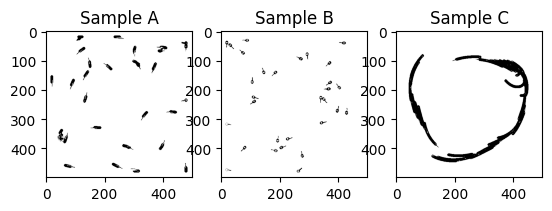

Random index selections:  4 6 14


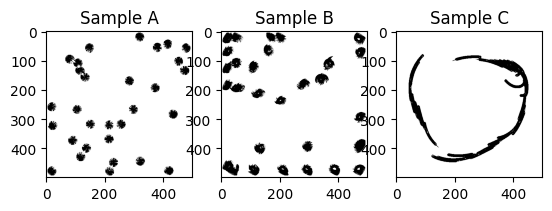

Random index selections:  3 7 14


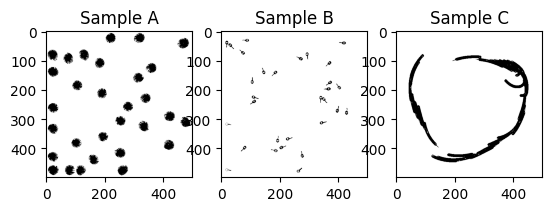

Eval Time
[0.6393331520748952, 0.22727990032546605, 0.18418207306894077, 0.3310253889834918, 0.632194177527629, 0.18299034164906405, 0.39473374827713054, 0.33471094282769775, 0.16628586333954018, 0.1896277345510419, 0.5318213050449674, 0.29471294439599904, 0.5962930420575063, 0.23232137022366608, 0.2386241072055809, 0.2821868348885361, 0.9493324108093428, 0.16654005903556465, 0.14575724663986409, 0.16784142598064525]
[(tensor([-0.2991]), 0), (tensor([-0.2991]), 1), (tensor([-0.2991]), 2), (tensor([-0.2991]), 3), (tensor([-0.2991]), 4), (tensor([-0.2991]), 5), (tensor([-0.2991]), 6), (tensor([-0.2991]), 7), (tensor([-0.2991]), 8), (tensor([-0.2991]), 9), (tensor([-0.2991]), 10), (tensor([-0.2991]), 11), (tensor([-0.2991]), 12), (tensor([-0.2991]), 13), (tensor([-0.2991]), 14), (tensor([-0.2991]), 15), (tensor([-0.2991]), 16), (tensor([-0.2991]), 17), (tensor([-0.2991]), 18), (tensor([-0.2991]), 19)]
Random index selections:  3 7 17


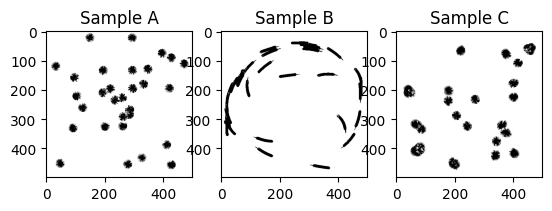

KeyboardInterrupt: 

In [33]:
from generation.halted_evolution import HaltedEvolution
K = 15
generator, screen = HaltedEvolution.defaultEvolver(steps=600, evolve_population=20, k_samples=K)
encodedArchive = NoveltyArchive(max_size=1000)
noveltyBlender = NoveltyScoreMixer()
writer = SummaryWriter()

optimizer = torch.optim.Adam(noveltyBlender.parameters(), lr=1e-3)
loss_fn = torch.nn.TripletMarginLoss()
generation_size = generator.evolve_config.generations
population_size = generator.evolve_config.population

for generation in range(generation_size):

    img_behaviors = []
    behavior_vectors = []
    b_novelty = []
    f_novelty = []
    genomes = []
    encodings = []
    sortable_scores = []
    blended_scores = [torch.Tensor([0.0]) for _ in range(population_size)]

    for i in range(population_size):
        X, b, genome = generator.next()
        genomes.append(genome)
        behavior_vectors.append(b)
        img_behaviors.append(X.copy())

        X = torch.Tensor(resizeInput(X)).to(device)
        X = torch.reshape(X, (1, 200*200))
        b = torch.Tensor(b).to(device)
        f_X = encoder.encoded(X)

        encoding = f_X.detach().cpu().squeeze(0).numpy()
        encodings.append(encoding)
        encodedArchive.addToArchive(encoding, genome)

        encodedArchive

    print("Eval Time")
    generator.behavior_discovery.evaluate()
    print(generator.behavior_discovery.scores)

    # for elem, encoded_b in enumerate(encodings):
    #     encoded_novelty = encodedArchive.getNovelty(K, encoded_b)
    #     f_novelty.append(encoded_novelty)
    #     behavior_novelty = generator.behavior_discovery.scores[elem]
    #     b_novelty.append(behavior_novelty)
    #     blend_out = noveltyBlender(torch.Tensor([encoded_novelty, behavior_novelty]))
    #     blended_scores[elem] = blend_out
    #     sortable_scores.append((blend_out, elem))

    generator.behavior_discovery.scores = blended_scores

    HIL_SAMPLES = 1
    total_loss = 0.0
    sortable_scores.sort()
    print(sortable_scores)
    for sample in range(HIL_SAMPLES):
        # Human in the Loop
        # Present the user with the top three images and ask them to rank them in terms of novelty
        split = population_size // 3
        a_index = random.randint(0, split - 1)
        b_index = random.randint(split, split * 2 - 1)
        c_index = random.randint(split*2, split * 3 - 1)

        print("Random index selections: ", a_index, b_index, c_index)
        a_index = sortable_scores[a_index][1]
        b_index = sortable_scores[b_index][1]
        c_index = sortable_scores[c_index][1]

        fig, (ax1, ax2, ax3) = plot.subplots(1, 3)
        ax1.imshow(img_behaviors[a_index], cmap="Greys")
        ax1.set_title("Sample A")
        ax2.imshow(img_behaviors[b_index], cmap="Greys")
        ax2.set_title("Sample B")
        ax3.imshow(img_behaviors[c_index], cmap="Greys")
        ax3.set_title("Sample C")
        plot.pause(2)

        responses = {
            "A" : a_index,
            "B" : b_index,
            "C" : c_index,
        }

        # Input A,B,C in ranked order in the form "ABC"
        time.sleep(0.2)
        user_res = ""
        while len(user_res) != 1 or not user_res.capitalize() in responses:
            user_res = input("Which one of these is least like the others?")
            if user_res == "q":
                break
            if user_res == "w":
                time.sleep(3)

        different_index = responses[user_res.capitalize()]
        res_to_same = list(responses.keys())
        res_to_same.remove(user_res.capitalize())
        same_indices = [responses[i] for i in res_to_same]
        assert len(same_indices) == 2

        anchor_out = noveltyBlender(torch.Tensor([f_novelty[same_indices[0]], b_novelty[same_indices[0]]]))
        pos_out = noveltyBlender(torch.Tensor([f_novelty[same_indices[1]], b_novelty[same_indices[1]]]))
        neg_out = noveltyBlender(torch.Tensor([f_novelty[different_index], b_novelty[different_index]]))

        optimizer.zero_grad()
        loss = loss_fn(anchor_out, pos_out, neg_out)
        loss.backward()
        total_loss += loss.item()
        optimizer.step()

    writer.add_scalar("mixer/loss", total_loss / HIL_SAMPLES, generation)

pygame.quit()